**Abstract: ** The paper reports on the initial research work investigating the feasibility, trustworthiness and transparency of the decisions driven by the complex Machine Learning models, the aspects especially important in context of mission-critical and high-impact automated control systems, such as the District Heating System. Specifically, the paper demonstrates and discusses the use of feature importances and counterfactual explanations of the local predictions made by the trained heat demand forecasting model. The analysis of the local feature importances by using SHAP method has uncovered humanly interpreted insights into the local model behavior and has confirmed the intuitive knowledge and common practices by the plant operators. Counterfactuals have been generated by using DiCE method. The paper specifically addressed the feasibility of the counterfactuals and proposed Euclidean distances as the simplistic but effective method for selecting the most actionable alternate strategy for achieving the operational goals as indicated in the analysis.

#Introduction#

The operation of District Heating System (DHS) plants primarily involves automated or semi-automated control of both primary (at the plant level) and secondary (at the substation level) supply water temperatures, as well as water flow in the primary supply line. Both primary and secondary flows operate in a closed loop, with energy transferred from the primary to secondary lines via a heat exchanger. Supply water temperature management relies on the overall DHS demand and current weather conditions. The DHS demand is quantified by the amount of heat energy transmitted within a specific interval, calculated as the difference between current and previous energy measurements recorded by a calorimeter located on the primary return line. Currently, conventional DHSs are managed by a Supervisory Control and Data Acquisition (SCADA) system, which integrates a range of sensors, control mechanisms, and algorithms to automatically adjust operational parameters based on sensor input. Control of DHS at the substation levels (primary and secondary sides) is fully automated. This includes the use of hot water reset controls (outdoor air reset or control curve), also known as a regulation curve, which the SCADA system uses to determine the desired supply line water temperature based on outside air temperature measurements. Such an approach to control is simplistic and reactive, as it depends only on the currently measured ambient temperature and manual plant operator decisions, driven by experience. Intelligent DHS control implements proactive, forecast-driven, automated operation decisions, which rely upon short and long-term forecasts of the heat demand, implemented by using modern Machine Learning models [1][2][3].

Performance of ML models goes much beyond the simplistic metrics used in practice and sadly even in academic research. This insight is inspired by rapidly increasing complexity of the ML models whose behavior is becoming difficult or even impossible to explain. That is considered as a significant risk in critical applications of Machine Learning having immediate impact at-scale, as is the case with District Heating and its environmental footprint. Blindly following the recommendations of forecasting models could lead to inefficient operation, suboptimal comfort levels for users and potential dissatisfaction, energy wastage, higher operational costs, wear on equipment and consequently, increased environmental footprint, financial losses and major operational disruptions. Hence, it is extremely important that forecasting is combined with real-time data monitoring, associated with manual fine tuning and contingency protocols.

Such real-time data monitoring can be implemented with assistance of modern Explainable AI (XAI) practices and corresponding insights. Commonly, XAI methods are used to assess feature importances, counterfactual explanations, anchors [4], prototypes [5], decision rules and other humanly interpretable notions. The methods can provide local (interpretation of the single prediction instance) or global (interpreting global model behavior) insights. They can be either ante-hoc (intrinsic to the algorithm used to train the model, interpretable by itself) or post-hoc (extrinsic, applicable to any trained model).

Explainable AI is a new emerging domain, integrating old and introducing new approaches to interpret the decisions made by complex intelligent systems. XAI can make demand forecast models more interpretable by explaining how certain features, like weather conditions or past consumption patterns, contribute to predicted heat demand. This transparency helps operators understand the reasoning behind specific predictions, allowing them to assess the reliability of forecasts and prepare contingency plans if certain assumptions are critical or uncertain. For instance, if the system adjusts the temperature of a heating fluid in a supply line, XAI can clarify which factors (such as a sudden temperature drop or unexpected high demand in certain areas) triggered the adjustments.

Also, XAI can provide means to maintain regulatory compliance and accountability. Many DHS systems operate under strict regulatory standards, especially concerning energy efficiency and emission levels. XAI enables operators to produce clear explanations for operational decisions, which can be essential for regulatory reporting or audits.

Surprisingly, there has been only a few research works addressing the issues of interpretability of models involved in DHS operation [1][6].

In this paper, we address selected local, post-hoc interpretability insights, potentially useful for assisting District Heating System automation, specifically for transparency of the heat demand forecasts. Those insights are local feature importances and counterfactual explanations. The paper introduces the approach to providing those insights and assesses their usability and quality in the context of a model for forecasting heat demand in the local plant.

# Background research

There exists a number of methods for local feature attribution, namely measuring feature importance at the level of a single prediction. Most commonly SHAP values and LIME are used as methods of choice.

LIME (Local Interpretable Model-agnostic Explanations) [7] approximates the model's behavior locally around a specific prediction by using a simpler, interpretable model, such as a linear model, in the vicinity of a specific data point. LIME starts by creating a new dataset consisting of perturbed versions of the original instance being explained. These perturbations are small random changes made to the input features. This new dataset helps explore how complex model's predictions change around the instance. The complex model is then used to predict the output for each perturbed instance in the new dataset. LIME assigns weights to the perturbed instances based on their similarity to the original instance. Perturbations that are more similar to the original data point receive higher weights, ensuring that the explanation focuses on the local behavior of the model. LIME then fits an interpretable model (e.g., a linear model) to the perturbed data, using the complex model's predictions as the target. This surrogate model approximates the complex model's behavior around the specific instance. The coefficients of the surrogate model provide insights into how each feature contributes to the complex model's prediction for the specific instance. These coefficients are used to generate an explanation, showing the contribution (positive or negative) of each feature to the prediction.

While LIME implements a performant solution which is applicable in quite many cases (lower dimensional data, minimal feature interactions), it also exhibits some weaknesses, most important being linear approximation, uncertainty in perturbation sampling (could easily go out of distribution), and assumed lack of feature interaction.

SHAP (SHapley Additive exPlanations) [8] values come from cooperative game theory and are used to fairly distribute the total gain (or loss) among players based on their contributions. A Shapley value for a feature represents its average contribution to the prediction across all possible combinations of features. SHAP can be used for both local and global explainability. SHAP values can explain individual predictions by showing how each feature contributes to that specific prediction. By aggregating SHAP values across many instances, SHAP can also provide insights into the overall importance of features and how they generally influence the model's predictions.
Counterfactual explanation is the “what-if" scenario that shows how the input features of an instance would need to change to achieve a different outcome from a predictive model. It is the measure of what minimal change to features is required to reclassify (classification) or change to a target value (regression) the current prediction. Counterfactual Instances (CI) [9] was an initially proposed method, with issue related to not necessarily generating interpretable counterfactuals, because the loss function did not effectively prevent the counterfactual solution from moving off the data distribution into unrealistic values (for example, ambient temperature greater than 100C). This issue is solved by Contrastive Explanation Method (CEM, Pertinent Negatives) [10], where counterfactual instances that deviate from the data distribution are penalized by autoencoder component. An even more effective approach to this issue was applied by Counterfactuals Guided by Prototypes (CGP) [11], hence generating more interpretable instances. There are more novel methods combining counterfactuals with Reinforcement Learning (CRL) [12]. This method uses a new trained Reinforcement Learning model to reward correctly classified or predicted counterfactuals. Also, counterfactuals that are close to the data distribution as modeled by an autoencoder are rewarded. Besides, the use of Reinforcement Learning enables us to take into account certain constraints (on the changes) when generating counterfactuals.

# Local insights and discussion#

Before implementing the code, neccessary libraries are installed and imported.

In [1]:
!pip install -q alibi
!pip install -q dice-ml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.1/522.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 93.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.
mizan

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import time
from scipy.stats import zscore
from IPython.display import Image, display, HTML
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


#Configuration parameters
github_folder = 'https://github.com/xai4heat/xai4heat/raw/main/datasets/'
file = 'xai4heat_scada_L17.csv'
substation='L17'
weather_file='weather/ni_20_rs.csv'

To demonstrate the selected local insights, a model for forecasting heat demand is trained by using historical hourly data from the SCADA (Supervisory Control and Data Acquisition) system of substation 17, operated by the Faculty of Mechanical Engineering. The dataset covers four heating seasons (2020–2024) and is augmented with meteorological data to provide additional predictors. Figure 1 illustrates the time series data for selected features within the specified period.

SCADA-supplied hourly data includes transmitted heating energy (deltae), ambient temperature (t_amb), secondary supply line water temperature (C, t_sup_sec), secondary return line water temperature (C, t_ret_sec), primary supply line water temperature (C, t_sup_prim), and primary return line water temperature (C, t_ret_prim). Additionally, various hourly meteorological variables, such as feels-like temperature, dew, wind direction, and others, are included.

Before training the model, the preprocessing steps involved retaining only full-hour data points, inserting missing time points with NaN values, addressing zero values in energy readings by marking them as missing values, adding basic time features like time of day, using linear interpolation to fill missing values, excluding data outside the heating season, removing features with a Pearson correlation coefficient below 0.1 to reduce model dimensionality, adjusting near-zero transmitted energy values to zero (to correct inaccurate readings), and removing outliers (z-score > 4), replacing them with linearly interpolated values. Each of these preprocessing tasks is further detailed and justified in [3].

In [3]:
#Opening and initial processing of weather data
dfw = pd.read_csv(github_folder+weather_file)
dfw['datetime'] = pd.to_datetime(dfw['datetime'])
dfw.set_index('datetime',inplace=True)

# Removing irrelevant data
dfw=dfw.drop(['name',
              'preciptype',
              'icon',
              'stations',
              'severerisk',
              'conditions'], axis=1)

#Opening and initial processing of DHS data + merging with weather
df = pd.read_csv(github_folder+file)
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime',inplace=True)

# Strip all data except data acquired at full hour
df = df[df.index.minute == 0]

#Insert missing timepoints, populate with NaNs
complete_time_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
df = df.reindex(complete_time_index)

#Merging with weather data
df = pd.merge(df, dfw, left_index=True, right_index=True, how='inner')

# zero data in e column is replaced with NaNs.
columns_to_update = ['t_sup_prim', 't_ret_prim']
df['e'] = df['e'].replace(0, np.nan)
for column in columns_to_update:
    df.loc[df['e'].isna(), column] = np.nan
df.interpolate(method='linear', inplace=True)


#Removing calorimeter readings data.
dropcolumns=['e',
             'pe']
df['hour_of_day'] = df.index.hour
deltae=(df['e']-df['e'].shift(1))*1000
df['heating_on'] = deltae.apply(lambda x: 1 if x > 11 else 0)
df['deltae']=deltae
df=df.drop(columns=dropcolumns, axis=1)
df=df.dropna()

# Remove data outside of the heating season
def strip_out_season_data(df):
  date_range_season1 = (df.index >= pd.to_datetime('2018-11-01 06:00:00')) & (df.index < pd.to_datetime('2019-04-01 00:00:00'))
  date_range_season2 = (df.index >= pd.to_datetime('2019-11-01 06:00:00')) & (df.index < pd.to_datetime('2020-04-01 00:00:00'))
  date_range_season3 = (df.index >= pd.to_datetime('2020-11-01 06:00:00')) & (df.index < pd.to_datetime('2021-04-01 00:00:00'))
  date_range_season4 = (df.index >= pd.to_datetime('2021-11-01 06:00:00')) & (df.index < pd.to_datetime('2022-04-01 00:00:00'))
  date_range_season5 = (df.index >= pd.to_datetime('2022-11-01 06:00:00')) & (df.index < pd.to_datetime('2023-04-01 00:00:00'))
  date_range_season6 = (df.index >= pd.to_datetime('2023-11-01 06:00:00')) & (df.index < pd.to_datetime('2024-04-01 00:00:00'))
  df = df[date_range_season1 | date_range_season2 | date_range_season3 | date_range_season4 | date_range_season5 | date_range_season6].copy()
  return df

df=strip_out_season_data(df)

#All features with correlation coefficient greater than 0.1 are kept in the dataset
# Calculate the correlation matrix
corr = df.corr()
#if 'deltae' in corr.columns:
deltae_corr = corr['deltae']
# Find features with correlation less than 0.1 in absolute value
low_corr_features = deltae_corr[deltae_corr.abs() < 0.1].index.tolist()
df=df.drop(low_corr_features, axis=1)

#Replacing data points with relatively small values of transmitted energy, close to zero, with zero
df['deltae'] = df['deltae'].apply(lambda x: 0 if x <= 31 else x)

#Outliers are removed and replaced with linearly interpolated values
zs = zscore(df['deltae'])
df.loc[np.abs(zs) > 4, 'deltae'] = np.nan
df['deltae'] = df['deltae'].interpolate(method='linear')

# Define your feature columns
features = ['deltae', 't_amb', 't_sup_prim', 't_ret_prim', 't_sup_sec', 't_ret_sec']
featurenames = ['deltae (kWh)', 't_amb (C)', 't_sup_prim (C)', 't_ret_prim (C)', 't_sup_sec (C)', 't_ret_sec (C)']

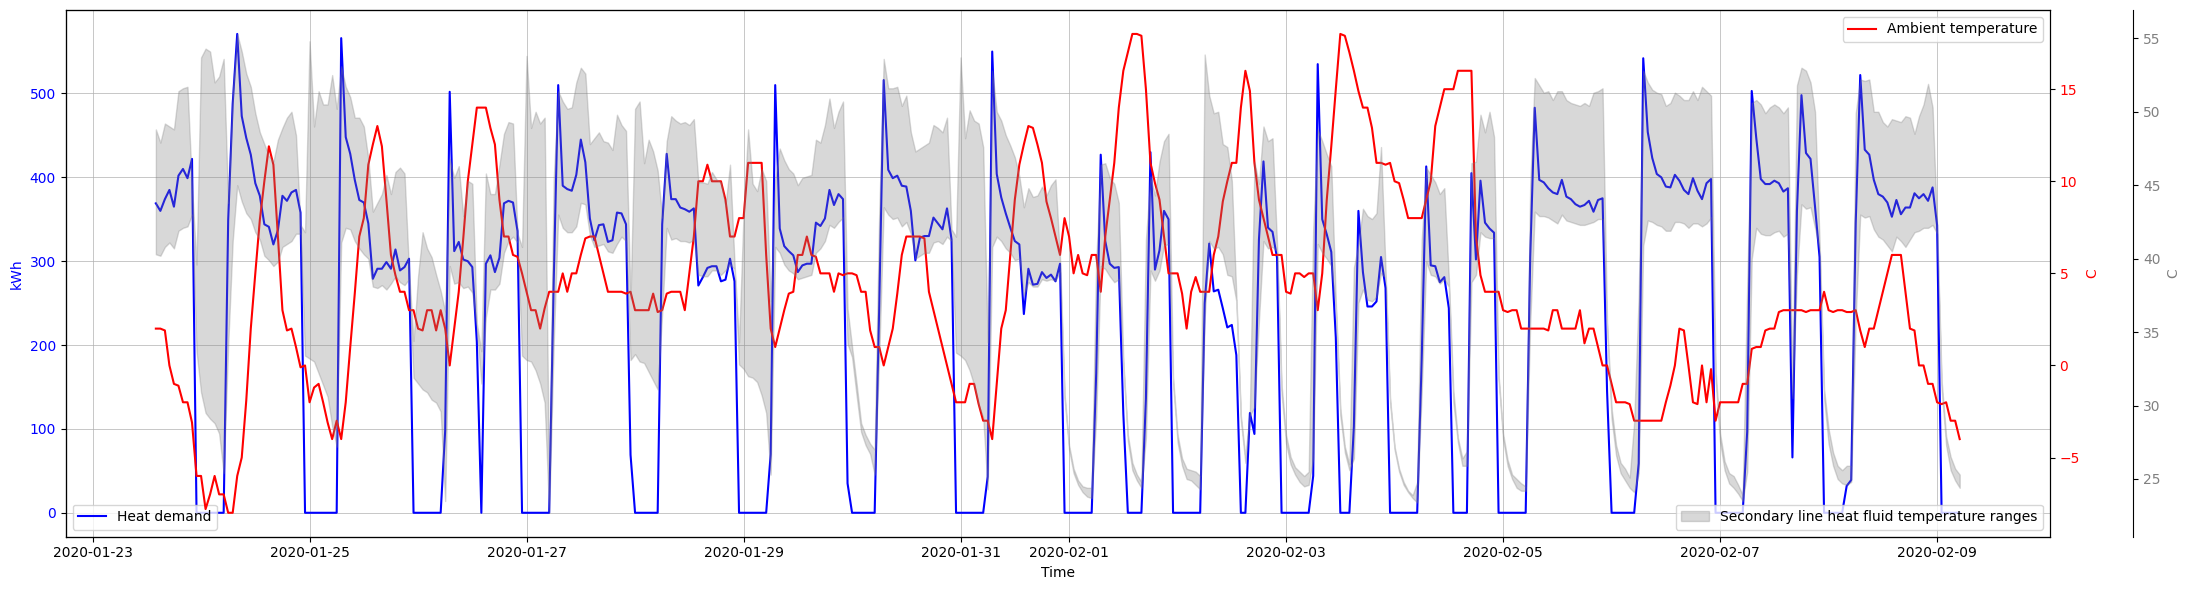

In [4]:
def plotTSBasic():
  # Define the range of indices around the specified instance within the test set
  start, end = 2000, 2400


  fig, ax1 = plt.subplots(figsize=(22, 6))

  # Plot actual deltae_forecast from the test set on the primary y-axis
  ax1.plot(df['deltae'].iloc[start:end], label='Heat demand', color='blue')
  ax1.set_xlabel("Time")
  ax1.set_ylabel("kWh", color='blue')
  ax1.tick_params(axis='y', labelcolor='blue')


  # Create a twin y-axis to plot t_amb from the test set
  ax2 = ax1.twinx()
  ax2.plot(df['temp'].iloc[start:end], label='Ambient temperature', color='red')
  ax2.set_ylabel("C", color='red')
  ax2.tick_params(axis='y', labelcolor='red')

  # Shade area between t_ret_sec and t_sup_sec on the third y-axis
  ax3 = ax1.twinx()
  ax3.spines['right'].set_position(('outward', 60))
  ax3.set_frame_on(True)
  ax3.patch.set_visible(False)
  ax3.set_ylabel("C", color='grey')
  ax3.tick_params(axis='y', labelcolor='grey')

  # Use fill_between to create a shaded area between t_ret_sec and t_sup_sec
  ax3.fill_between(df.index[start:end],
                 df['t_ret_sec'].iloc[start:end],
                 df['t_sup_sec'].iloc[start:end],
                 color='grey', alpha=0.3, label='Secondary line heat fluid temperature ranges')

  # Adding a legend and title
  ax1.legend(loc="lower left")
  ax2.legend(loc="upper right")
  ax3.legend(loc="lower right")
  #plt.title("Time series data from index "+str(start)+" to "+str(end))
  fig.tight_layout()
  ax1.grid(True, which='both', axis='both', linewidth=0.5)
  plt.show()

plotTSBasic()


*Figure 1. Line plots of the selected data features in example interval*

Then, the processed data is used to train the regressor (by using XGBoost algorithm) model. Before training, data is enriched with time-lagged transmitted energy (deltae-1 to deltae-23) and ambient temperature (temp-1 to temp-23) in the past 24 hours which are introduced as new features. 80% of available data is used for training and the remaining 20% is used for testing the trained models. Mean Absolute Error (MAE) is adopted as a simplistic metric for regression problems, with achieved MAE=31.81 kWh. The model was not optimized or associated with more advanced metrics because the purpose of this research was to investigate the opportunities of use of XAI insights and not to achieve maximum accuracy.

In [5]:
#Time lagged transmitted energy and ambient temperature in the past 24 hours are introduced as features
for c in range(24):
    df['deltae-'+str(c+1)]=df['deltae'].shift(c+1)
    df['temp-'+str(c+1)]=df['temp'].shift(c+1)

# 80% of data used for training, 20% for testing
train_size=int(0.8*len(df))

# Target variable is introduced
df['deltae_forecast']=df['deltae'].shift(-1)
df=df.dropna()

# Input and output data
X = df.drop(columns=['deltae_forecast'], axis=1)
y = df['deltae_forecast']
yc= df['deltae_forecast'].apply(lambda x: 1 if x > 0 else 0)

# Train and test sets for regression and classification problems created
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

# XGBoost regression model trained and tested on MAE
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
xgb_mae = mean_absolute_error(y_test, y_pred)
print("XGB Mean Absolute Error (MAE):", xgb_mae)

XGB Mean Absolute Error (MAE): 31.812961146226666


## Local feature importance ##

For assessing the local feature importance, namely the contributions of the specific features of the individual data instance to the prediction, the SHAP method was used as commonly adopted standard for providing global and local feature importance insights.

For each feature, SHAP calculates the contribution by considering the difference in the model's prediction with and without the feature - a marginal contribution. This is done by evaluating all possible combinations of feature subsets (also known as coalitions) with and without the feature and averaging the marginal contributions of the feature across all these combinations. The SHAP value for a feature i in a specific prediction is computed as follows:

$\phi_i = \sum_{S \subseteq N \setminus \{i\}} \frac{|S|!(|N| - |S| - 1)!}{|N|!} \left[ f(S \cup \{i\}) - f(S) \right]$

- S is a subset of features not including feature i,
- N is a set of all features,
- |S| is the number of features in subset S,
- f(S) is the model's prediction given the features in subset S,
- f(S U {i}) is The model's prediction given the features in subset S plus feature i,
- $\frac{|S|!(|N| - |S| - 1)!}{|N|!}$ is the weighting factor that ensures fair distribution of the marginal contribution across all possible subsets,
- $\phi_i$ is the SHAP value for feature i, representing its contribution to the difference between the actual prediction and the baseline prediction.

Model's prediction for the specific instance equals the sum of all SHAP values for an instance and baseline value:

$f(x) = E[f(X)] + \sum_{i=1}^{n} \phi_i$

The baseline prediction, denoted as E[f(X)], is the average prediction across the entire training dataset. This is the prediction that would be made if no features were used (i.e., if we had no specific information about any instance). It represents the "average" model behavior or outcome across all instances.

SHAP waterfall plot is a local explanation visualization method used to illustrate how different features contribute to the prediction for a specific instance. The plots at Figure 2 present the local feature importances for two specific predictions, at the same time of two consecutive days. The baseline prediction in this case is 161.824 kWh. The model's predictions for this specific instance are 404.364 kWh and 366.427 kWh, respectively. Each feature's contribution to the final prediction is represented by a bar. The bars show how much each feature pushes the prediction away from the baseline prediction.

In both local forecasts, SHAP analysis has uncovered the relevance of the time of a day and heat demand at the same hour of the previous day (deltae-23), both of which insights are strong evidence of the captured daily seasonality but also of the competence of the SHAP method to acknowledge this seasonality.

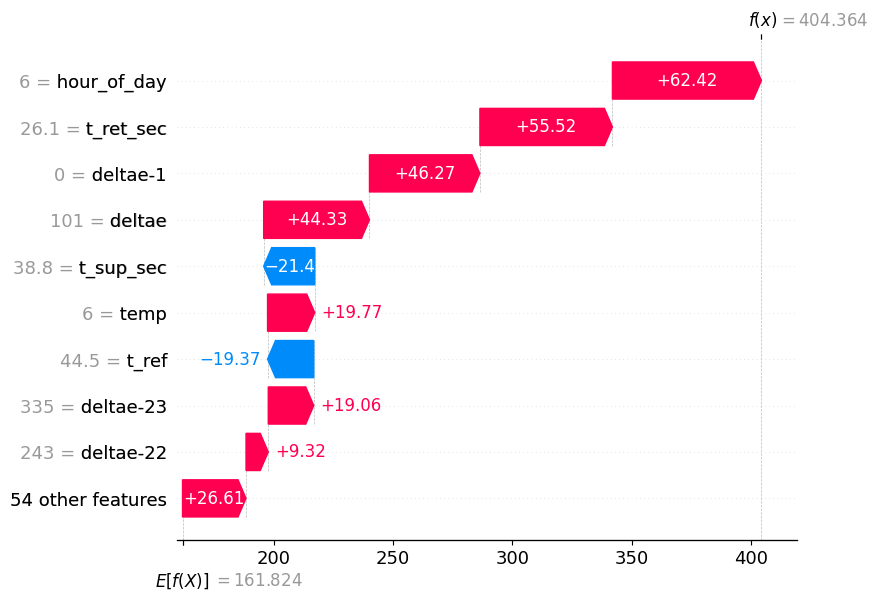

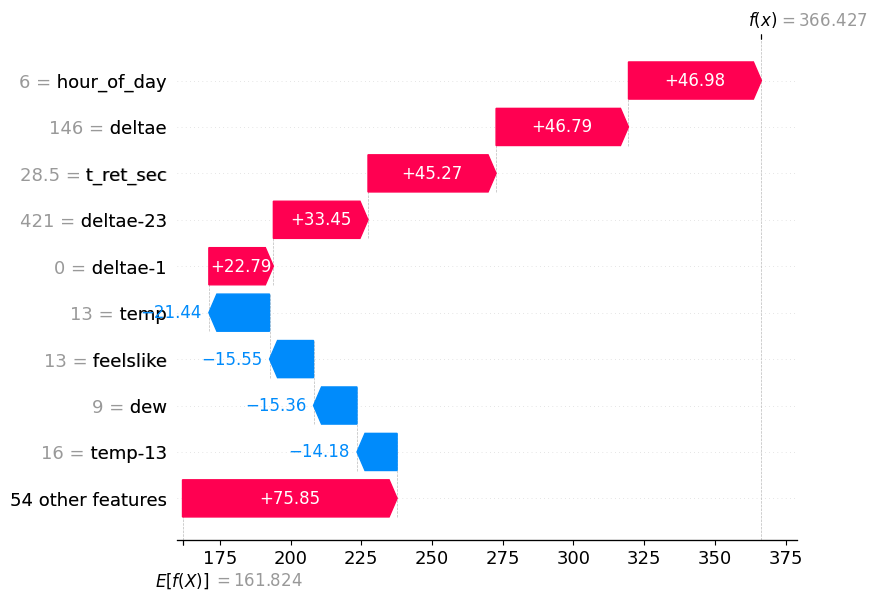

In [6]:
import shap
instance_index = 322

def plotSHAPwp(instance_index):
  # Initialize the SHAP explainer
  explainer = shap.Explainer(xgb_model, X_train)

  # Select a single instance from your test set to explain
  shap_values = explainer(X_test.iloc[instance_index:instance_index+1])

  # Visualize the SHAP values using a waterfall plot
  shap.waterfall_plot(shap_values[0])

plotSHAPwp(instance_index)
plotSHAPwp(instance_index-24)

*Figure 2. SHAP waterfall plots for two data instances*

The plots at Figure 3 below show the actual (blue line) and predicted (green dashed line) heat demand in the two local predictions and three other time series features, identified as important in SHAP analysis above: temperatures of the heating fluid in secondary supply (t_sup_sec) and return (t_ret_sec) lines and ambient temperature measured by the meteorological station (temp).

Green line indicates the index of the local prediction time point, used in SHAP analysis above. Blue dots mark the heat demand data points discovered as the lagged features with highest SHAP values, namely deltae, deltae-1, delta-22 and delta-23 in the first case, and deltae, deltae-1 and delta-23 in the second one. Similarly, grey dots mark the t_ret_sec and t_sup_sec datapoints of high SHAP values and green dot highlights the predicted heat demand value for the specified index.

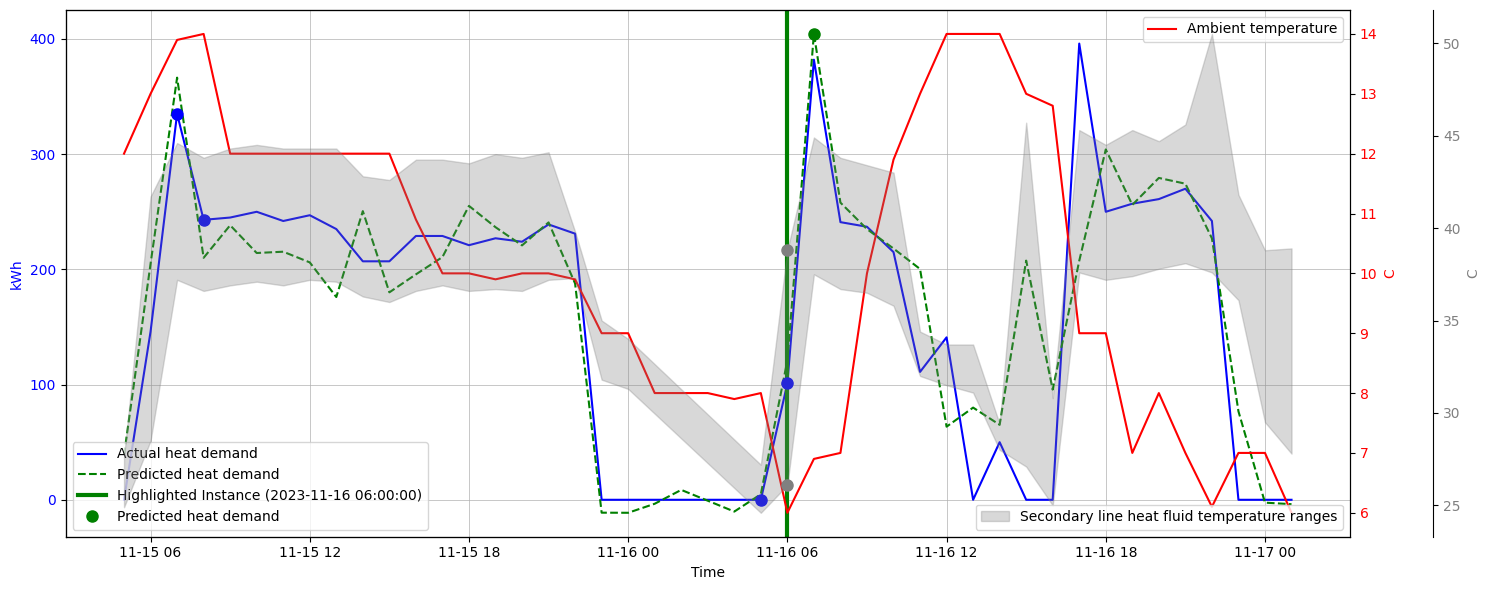

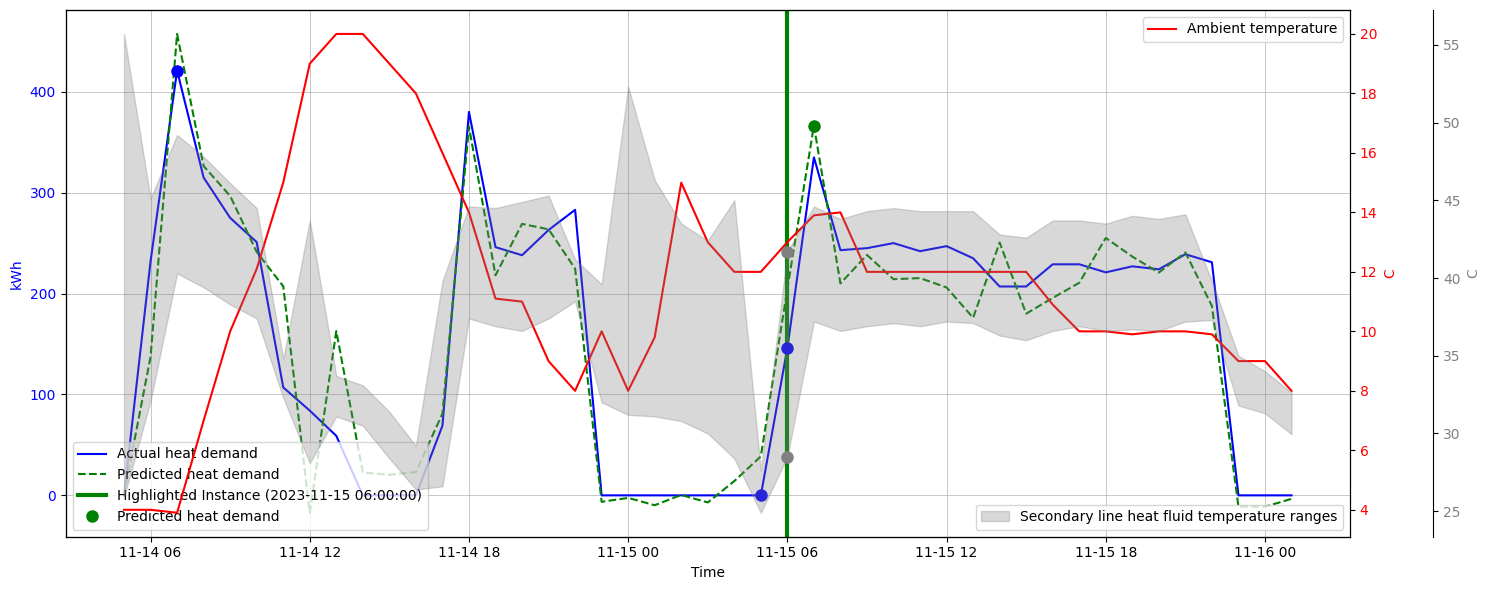

In [8]:
highlight_lags = [0, 1, 22, 23]

def plotTS(instance_index, highlight_lags):
  # Define the range of indices around the specified instance within the test set
  start, end = instance_index - 25, instance_index + 20

  df_test = df.iloc[train_size:].copy()
  df_test_shifted=df_test.shift(1)

  # Create a DataFrame for predicted values with the test set's datetime index
  y_pred_df = pd.DataFrame(y_pred, index=df_test.index, columns=['deltae_forecast_pred']).shift(1)

  fig, ax1 = plt.subplots(figsize=(15, 6))

  # Plot actual deltae_forecast from the test set on the primary y-axis
  ax1.plot(df_test_shifted['deltae_forecast'].iloc[start:end], label='Actual heat demand', color='blue')
  ax1.set_xlabel("Time")
  ax1.set_ylabel("kWh", color='blue')
  ax1.tick_params(axis='y', labelcolor='blue')

  # Plot predicted deltae_forecast values from y_pred_df with the test set's datetime index
  ax1.plot(y_pred_df['deltae_forecast_pred'].iloc[start:end], label='Predicted heat demand', color='green', linestyle='--')

  # Create a twin y-axis to plot t_amb from the test set
  ax2 = ax1.twinx()
  ax2.plot(df_test['temp'].iloc[start:end], label='Ambient temperature', color='red')
  ax2.set_ylabel("C", color='red')
  ax2.tick_params(axis='y', labelcolor='red')

  # Shade area between t_ret_sec and t_sup_sec on the third y-axis
  ax3 = ax1.twinx()
  ax3.spines['right'].set_position(('outward', 60))
  ax3.set_frame_on(True)
  ax3.patch.set_visible(False)
  ax3.set_ylabel("C", color='grey')
  ax3.tick_params(axis='y', labelcolor='grey')

  # Use fill_between to create a shaded area between t_ret_sec and t_sup_sec
  ax3.fill_between(df_test.index[start:end],
                 df_test['t_ret_sec'].iloc[start:end],
                 df_test['t_sup_sec'].iloc[start:end],
                 color='grey', alpha=0.3, label='Secondary line heat fluid temperature ranges')

  # Retrieve the datetime index value for the instance index 191
  highlight_date = df_test.index[instance_index]

  # Add a vertical line at the datetime index of instance_index to highlight it
  ax1.axvline(x=highlight_date, color='green', linewidth=3, label='Highlighted Instance ('+str(highlight_date)+')')


  # Highlight specific points with circles

  for lag in highlight_lags:
    # Get the datetime for the lagged index
    lagged_date = df_test.index[instance_index - lag]
    # Plot a circle for actual deltae_forecast at the lagged point
    ax1.plot(lagged_date, df_test_shifted['deltae_forecast'].loc[lagged_date], 'o', color='blue', markersize=8)

  ax1.plot(df_test.index[instance_index+1], y_pred_df['deltae_forecast_pred'].loc[df_test_shifted.index[instance_index+1]], 'o', color='green', markersize=8, label='Predicted heat demand')  # Label only once

  # Highlight t_ret_sec and t_sup_sec at highlight_date
  ax3.plot(highlight_date, df_test['t_ret_sec'].loc[highlight_date], 'o', color='grey', markersize=8)
  ax3.plot(highlight_date, df_test['t_sup_sec'].loc[highlight_date], 'o', color='grey', markersize=8)


  # Adding a legend and title
  ax1.legend(loc="lower left")
  ax2.legend(loc="upper right")
  ax3.legend(loc="lower right")
  #plt.title("Plot of Actual and Predicted hourly heat demand, ambient temperature and \nsecondary line heat fluid temperatures from index "+str(start)+" to "+str(end))
  fig.tight_layout()
  ax1.grid(True, which='both', axis='both', linewidth=0.5)

  plt.show()

plotTS(instance_index, highlight_lags)
plotTS(instance_index-24, [0, 1, 23])


*Figure 3. Line plots of the heat demand and other features with highlighted data points*

The local explanation provided by the feature importance perspective is intuitive from the domain expertise point of view and this is clearly illustrated in the plots. SHAP has found the current heat demand, and demand at the similar time in past day as lagged features of high relevance. This implies that the strong daily seasonality of the DHS operation is acknowledged by the model and uncovered by SHAP in case of these local predictions. Besides that, SHAP highlights deltae-1=0 as the third and fifth most important feature for these predictions, respectively. Here, the heat demand is predicted in the second hour after the daily cycle of the DHS operation started and heating is turned on. High predicted value is normally expected because the heat transfer in the first few hours is intensive and delivered heat energy grows at a steep rate. Again, not only does that model work as expected in these cases, but also even SHAP successfully explained the model's reasoning.

Such model behavior combined with the chosen approach to interpreting the model's reasoning, is extremely important for validating the DHS operation decisions based on the heat demand forecasts, with condition that those qualities are consistently exhibited. This consistency has been proven with the experiment on global feature importance on the same dataset and reported in another paper [13].

## Counterfactual explanations

For generating counterfactuals, DiCE (Diverse Counterfactual Explanations) [14] was used. DiCE is a Python library implementing model agnostic method that generates counterfactual explanations for Machine Learning models. DiCE offers multiple counterfactuals, each differing in the features they modify. This helps users understand the different paths that could lead to a different outcome, offering more flexibility and deeper insight.

DiCE enables us to specify which features are allowed to change, set bounds or ranges for feature changes. It supports different methods for generating counterfactuals, including random (generates random perturbations of the input features), genetic (uses genetic algorithms to evolve counterfactuals), and gradient-based (uses gradients to identify minimal changes needed to flip the model's prediction). The latter two methods are optimization-based approaches.

To demonstrate the value of counterfactuals in DHS operation, we use DiCE on previously trained regression model for heat demand forecasting. The implementation code generates counterfactuals for a target value (a specific value one wants to achieve in the counterfactual). The table below shows the explanations on how to change temperatures of supply lines in secondary (t_sup_sec) or primary flow (t_sup_prim) in order to increase the transmitted heat in the next time step for 50 kWh. To allow for flexibility, the method implements search for increase of the transmitted heat energy in an interval of (50-20, 50+20) kWh. Ten counterfactuals were requested.

In [157]:
import dice_ml
from dice_ml.utils import helpers

# Defines the list of continuous features to consider for generating counterfactuals, excluding the target variable deltae_forecast.
cfs=list(dfc.drop(['deltae_forecast'],axis=1).columns)
#the features allowed to vary when generating counterfactuals.
pr=['t_sup_sec', 't_sup_prim']

# Sets up the DiCE data object using the df DataFrame with deltae_forecast as the outcome. cfs specifies the continuous features for this regression model.
data = dice_ml.Data(dataframe=df,
                    continuous_features=cfs,
                    outcome_name='deltae_forecast')

# Wraps the xgb_model in a DiCE model object with sklearn as the backend, specifying that it’s a regression model (model_type="regressor").
model = dice_ml.Model(model=xgb_model,
                      backend="sklearn",
                      model_type="regressor")

# Creates a DiCE explainer with a geneetic method for generating counterfactuals.
exp = dice_ml.Dice(data, model, method="random")

# Specify the Instance to Explain:
query_instance = df.drop(['deltae_forecast'],axis=1).iloc[train_size+instance_index:train_size+instance_index+1]

# Specify a target value for the counterfactual (e.g., reduce deltae_forecast)
target_value = df['deltae_forecast'].values[train_size+instance_index] + 50
counterfactuals = exp.generate_counterfactuals(query_instance,
                                               total_CFs=10,
                                               desired_range=[target_value-20, target_value+20],
                                               features_to_vary=pr,
                                               )
counterfactuals.visualize_as_dataframe(show_only_changes=True, display_sparse_df=False)

100%|██████████| 1/1 [00:01<00:00,  1.93s/it]

Query instance (original outcome : 404.0)


,t_amb,t_ref,t_sup_prim,t_ret_prim,t_sup_sec,t_ret_sec,temp,feelslike,dew,snowdepth,...,temp-20,deltae-21,temp-21,deltae-22,temp-22,deltae-23,temp-23,deltae-24,temp-24,deltae_forecast
0,7.9,44.5,65.900002,37.099998,38.799999,26.1,6.0,6.0,6.0,0.0,...,12.0,245.0,12.0,243.0,14.0,335.0,13.9,146.0,13.0,404.0



Diverse Counterfactual set without sparsity correction (new outcome:  [412.0000000014261, 452.0000000014261]


,t_amb,t_ref,t_sup_prim,t_ret_prim,t_sup_sec,t_ret_sec,temp,feelslike,dew,snowdepth,...,temp-20,deltae-21,temp-21,deltae-22,temp-22,deltae-23,temp-23,deltae-24,temp-24,deltae_forecast
0,-,-,53.2,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
1,-,-,101.3,-,41.3,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,422.0
2,-,-,100.1,-,42.8,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,422.0
3,-,-,97.0,-,45.8,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
4,-,-,100.4,-,41.2,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,422.0
5,-,-,94.9,-,42.5,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,422.0
6,-,-,94.1,-,40.3,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,422.0
7,-,-,96.3,-,42.1,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,422.0
8,-,-,94.3,-,42.5,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,422.0
9,-,-,96.6,-,44.6,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-


It is important to highlight that the results above show that in some cases, even though counterfactual instances produced increase in delivered energy transmitted, those values did not achieve the target outcome range (symbol '-' in the image). Some of the most probable reasons are restricted scope of change (in this case, only two features are varied) or too specific desired range (target increase-20, target in-crease+20).

In the above case, temperatures of heating fluid in supply line of primary and secondary subsystems were used as varying features because those can be controlled in custom SCADA processes. In other words, plant operators can make operational decisions which could affect the changes in those supply lines.
There are several scenarios where an operator might choose to deliver more or less energy than predicted by the model, despite accurate forecasting. In anticipation of rapid weather changes, an operator may increase supply temperatures in advance to ensure the system responds quickly enough to meet sudden demand spikes. Furthermore, operators may choose to "overheat" or "underheat" the system slightly to account for the delay caused by thermal inertia, ensuring that energy demand is met consistently. In situations where heat loss is more significant, such as areas further from the main plant, operators might choose to deliver slightly more energy to ensure that heat losses are compensated.

Before using generated counterfactuals in alternate operation strategies, they need to be verified. This verification includes feasibility analysis. First, it is necessary to check if the suggested changes are even possible given the plant and substation control capabilities. This check is performed by validating if the changes requested by the counterfactuals fall within the distribution of possible changes.

Those requested changes are highlighted below.

In [158]:
dd=pd.DataFrame(counterfactuals.cf_examples_list[0].final_cfs_df[['t_sup_prim', 't_sup_sec', 'deltae_forecast']])
original_tsupprim=query_instance.iloc[0]['t_sup_prim']
original_tsupsec=query_instance.iloc[0]['t_sup_sec']
dd['t_sup_prim_change']=dd['t_sup_prim']-original_tsupprim
dd['t_sup_sec_change']=dd['t_sup_sec']-original_tsupsec
print(dd)

   t_sup_prim  t_sup_sec  deltae_forecast  t_sup_prim_change  t_sup_sec_change
0        53.2       38.8            413.0              -12.7               0.0
1       101.3       41.3            422.0               35.4               2.5
2       100.1       42.8            422.0               34.2               4.0
3        97.0       45.8            421.0               31.1               7.0
4       100.4       41.2            422.0               34.5               2.4
5        94.9       42.5            422.0               29.0               3.7
6        94.1       40.3            422.0               28.2               1.5
7        96.3       42.1            422.0               30.4               3.3
8        94.3       42.5            422.0               28.4               3.7
9        96.6       44.6            421.0               30.7               5.8


Distributions of the above changes in whole dataset are plotted in histograms below. Maximum differences were also printed. It can be concluded that the suggested increases or decreases of the heating fluid temperatures in supply lines of the primary and secondary flows fall within distribution, hence, they are feasible with the current capacity of the system operation.

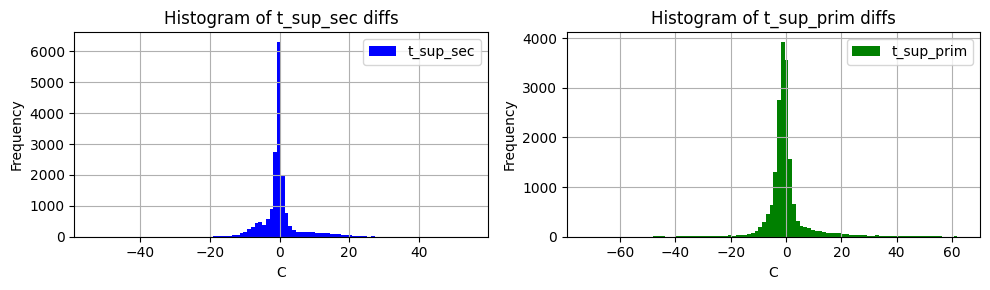

Max of t_sup_sec in the dataset: 54.3
Max of t_sup_prim in the dataset: 63.400000000000006


In [164]:
df1=df.copy()

# Create the shifted versions for the next time step
df1['t_sup_sec_diff'] = df1['t_sup_sec'].shift(-1)-df1['t_sup_sec']
df1['t_sup_prim_diff'] = df1['t_sup_prim'].shift(-1)-df1['t_sup_prim']

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

# Plot histogram for 't_sup_sec' and 't_sup_sec_next' in the first subplot
ax1.hist(df1['t_sup_sec_diff'].dropna(), bins=100, label='t_sup_sec', color='blue')
ax1.set_title('Histogram of t_sup_sec diffs')
ax1.set_xlabel('C')
ax1.set_ylabel('Frequency')
ax1.legend()
ax1.grid(True)

# Plot histogram for 't_sup_prim' and 't_sup_prim_next' in the second subplot
ax2.hist(df1['t_sup_prim_diff'].dropna(), bins=100, label='t_sup_prim', color='green')
ax2.set_title('Histogram of t_sup_prim diffs')
ax2.set_xlabel('C')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

original_instance = query_instance.iloc[0][common_features].values

print("Max of t_sup_sec in the dataset: " + str(max(df1['t_sup_sec_diff'])))
print("Max of t_sup_prim in the dataset: " + str(max(df1['t_sup_prim_diff'])))

*Figure 4. Distribution of hourly changes of heating fluid temperatures in supply lines of pri-mary lines of secondary and primary flow*

The above check is simplistic and serves as an initial insight. In some cases, with strong dependencies between the varying and other features (such as the dependency between t_sup_sec and t_sup_prim in this case), the distribution check may not be sufficient.

In order to analyze and even compare the feasibilities of each of the suggested counterfactuals, leading to corresponding operating decisions, we propose using the distance measures. Distance measures are widely used to assess how similar or different two data points are, in the multidimensional space. Different distance measures can be used, such as Euclidean (L2 Norm), Manhattan (L1 Norm), Chebyshev and Mahalanobis.

In this paper, Euclidean distance is used to provide insight into the feasibility of the individual counterfactuals. Euclidean distance between two data points is calculated as:

$d_{L2}(x, x_{cf}) = \sqrt{\sum_{i=1}^n (x_i - x_{cf_i})^2}$

- n - number of features
- x = (x1,..xn) - original data point
- xcf = (xcf1,..,xcfn) - Counterfactual data point

A smaller L2 distance indicates that the counterfactual is close to the original instance, often meaning that it requires fewer or smaller changes to achieve the target outcome, making it potentially more actionable or realistic.

The Euclidean distances between the original instance for which the counterfactuals are requested and counterfactuals themselves are presented in Figure 6 below.

In [166]:
# Get the intersection of columns between query_instance and final_cfs_df to ensure alignment
common_features = query_instance.columns.intersection(counterfactuals.cf_examples_list[0].final_cfs_df.columns)
original_instance = query_instance.iloc[0][common_features].values

# Calculate the L2 norm distance between the original instance and each counterfactual, aligned on common features
distances = counterfactuals.cf_examples_list[0].final_cfs_df[common_features].apply(
    lambda x: np.linalg.norm(x.values - original_instance), axis=1
)

dd['l2_distances']=distances
dd.style.background_gradient(cmap='Blues')

,t_sup_prim,t_sup_sec,deltae_forecast,t_sup_prim_change,t_sup_sec_change,l2_distances
0,53.200000,38.800000,413.000000,-12.700000,0.000000,12.700000
1,101.300000,41.300000,422.000000,35.400000,2.500000,35.488167
2,100.100000,42.800000,422.000000,34.200000,4.000000,34.433124
3,97.000000,45.800000,421.000000,31.100000,7.000000,31.878049
4,100.400000,41.200000,422.000000,34.500000,2.400000,34.583378
5,94.900000,42.500000,422.000000,29.000000,3.700000,29.235082
6,94.100000,40.300000,422.000000,28.200000,1.500000,28.239865
7,96.300000,42.100000,422.000000,30.400000,3.300000,30.578587
8,94.300000,42.500000,422.000000,28.400000,3.700000,28.640007
9,96.600000,44.600000,421.000000,30.700000,5.800000,31.243079


With this insight, the operator can choose the most feasible strategy for increasing the transmitted energy in the next hour, by adopting the counterfactuals with the minimum L2 distance from the original instance, in this case instance 6.

In [168]:
ddd=dd[dd['deltae_forecast'] == dd['deltae_forecast'].max()]
ddd=ddd[ddd['l2_distances'] == ddd['l2_distances'].min()]
ddd.style.background_gradient(cmap='Blues')

,t_sup_prim,t_sup_sec,deltae_forecast,t_sup_prim_change,t_sup_sec_change,l2_distances
6,94.100000,40.300000,422.000000,28.200000,1.500000,28.239865


# Conclusions

Having humans in the loop when complex control systems are implemented is important for many reasons already highlighted in this paper. Building on the vast opportunities for automation, brought by the Machine Learning models, introduces significant additional complexity in control, making human oversight difficult if not impossible. In this paper, it was demonstrated that Explainable AI techniques can be used to better align the effectiveness and efficiency of Machine Learning-driven decisions with intuition and domain knowledge, currently exclusive to humans. The example of local feature importance insights into heat demand forecasts used for generating operation strategies of the District Heating Systems demonstrates this alignment, contributing to the overall trustworthiness, reducing risks of missed overrides, but also to the model improvement and adaptation.

Counterfactuals are potentially very useful insights into the local predictions. They can serve to investigate what-if scenarios and to generate practical and realistic recommendations in automated control systems scenarios, especially when using optimization-based methods. However, it is important to highlight that generating counterfactual by relying on the existing methods is not sufficient. In this paper we introduced Euclidean distances as simplistic approach to examining feasibility of the control strategies suggested by the generated counterfactuals. This is only an illustration of the approach. While it generates meaningful insights, this specific approach is yet insufficient in most of the practical cases. For example, Euclidean distance treats all features equally, but some features might be more critical or easier to change in practical terms. Using weighted Euclidean distances (based on feature importance) could address this. Also, Euclidean distance is linear, so it doesn’t account for nonlinear interactions between features, which may be essential in complex models.


#Acknowledgement

This research was supported by the Science Fund of the Republic of Serbia, Grant No. 23-SSF-PRISMA-206, Explainable AI-assisted operations in district heating systems - XAI4HEAT.

#References#

1.	Zdravković, M., Ignjatović, M., Ćirić, I. (2022) Explainable heat demand forecasting for the novel control strategies of district heating systems. Annual Reviews in Control. 53 (2022): 405-413. DOI: 10.1016/j.arcontrol.2022.03.009
2.	Zdravković, M. et al. (2024). XAI4HEAT: Towards Demand-Driven, AI Facilitated Management of District Heating Systems. In: Trajanović, M., Filipović, N., Zdravković, M. (eds) Disruptive Information Technologies for a Smart Society. ICIST 2024. Lecture Notes in Networks and Systems, vol 860. Springer, Cham. https://doi.org/10.1007/978-3-031-71419-1_3
3.	Zdravković, M. (2024). XGBoost “is All You Need”: the Case of Forecasting Transmit-ted Heat Energy in District Heating Systems. In: Trajanović, M., Filipović, N., Zdravković, M. (eds) Disruptive Information Technologies for a Smart Society. ICIST 2024. Lecture Notes in Networks and Systems, vol 860. Springer, Cham. https://doi.org/10.1007/978-3-031-71419-1_2
4.	Ribeiro, M. T., Singh, S., & Guestrin, C. (2018). Anchors: High-precision model-agnostic explanations. Proceedings of the Thirty-Second AAAI Conference on Artificial Intelligence and Thirtieth Innovative Applications of Artificial Intelligence Conference and Eighth AAAI Symposium on Educational Advances in Artificial Intelligence.
5.	Bien, J., & Tibshirani, R. (2011). Prototype selection for interpretable classification. The Annals of Applied Statistics, 5(4). https://doi.org/10.1214/11-AOAS495
6.	Huang, Y., Zhao, Y., Wang, Z., Liu, X., Liu, H., & Fu, Y. (2023). Explainable district heat load forecasting with active deep learning. Applied Energy, 350, 121753. https://doi.org/10.1016/j.apenergy.2023.121753
7.	Ribeiro, M. T., Singh, S., & Guestrin, C. (2016). “Why Should I Trust You?”: Explain-ing the Predictions of Any Classifier. Proceedings of the 22nd ACM SIGKDD Interna-tional Conference on Knowledge Discovery and Data Mining, 1135–1144. https://doi.org/10.1145/2939672.2939778
8.	Lundberg, S., & Lee, S.-I. (2017). A Unified Approach to Interpreting Model Predic-tions. arXiv:1705.07874 [Cs, Stat]. http://arxiv.org/abs/1705.07874
9.	Wachter, S., Mittelstadt, B., & Russell, C. (2017). Counterfactual Explanations without Opening the Black Box: Automated Decisions and the GDPR. https://doi.org/10.48550/ARXIV.1711.00399
10.	Dhurandhar, A., Chen, P.-Y., Luss, R., Tu, C.-C., Ting, P., Shanmugam, K., & Das, P. (2018). Explanations based on the Missing: Towards Contrastive Explanations with Per-tinent Negatives (Version 2). arXiv. https://doi.org/10.48550/ARXIV.1802.07623
11.	Van Looveren, A., & Klaise, J. (2019). Interpretable Counterfactual Explanations Guid-ed by Prototypes (Version 2). arXiv. https://doi.org/10.48550/ARXIV.1907.02584
12.	Samoilescu, R.-F., Van Looveren, A., & Klaise, J. (2021). Model-agnostic and Scalable Counterfactual Explanations via Reinforcement Learning (Version 1). arXiv. https://doi.org/10.48550/ARXIV.2106.02597
13.	Zdravković, M. (2024) On the global feature importance for interpretable and trustwor-thy heat demand forecasting. SIMTERM 2024. Accepted paper.
14.	Mothilal, R. K., Sharma, A., & Tan, C. (2020). Explaining machine learning classifiers through diverse counterfactual explanations. Proceedings of the 2020 Conference on Fairness, Accountability, and Transparency, 607–617. https://doi.org/10.1145/3351095.3372850